In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [35]:
play_df = pd.read_csv('d20_intermediate_files/play_results.csv')
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv')

In [46]:
def smooth(series, window=5, centering=True):
    s_df = series.rolling(window=window, win_type='gaussian', center=centering).mean(std=1)
    return s_df.dropna()

In [47]:
def plot_prob_heatmap(df, x_col, x_dim, y_col, y_dim, game_id, play_id):

    def normalise_df(df_n):
        return df_n / df_n.max() * 0.999

    x = smooth(normalise_df(df.loc[(df['gameId'] == game_id) & (df['playId'] == play_id)][x_col])).tolist()
    y = smooth(normalise_df(df.loc[(df['gameId'] == game_id) & (df['playId'] == play_id)][y_col])).tolist()

    bins = np.zeros(x_dim * y_dim).reshape((x_dim, y_dim))

    for frame in zip(x, y):
        x_bin = int(np.floor(frame[0] * x_dim))
        y_bin = int(np.floor(frame[1] * y_dim))
        bins[x_bin][y_bin] = bins[x_bin][y_bin] + 1

    binned_p = np.zeros(x_dim * y_dim).reshape((x_dim, y_dim))

    for i in range(0, x_dim):
        for j in range(0, y_dim):
            count = 0
            samples = 0
            for row in range(-1, 2):
                for col in range(-1, 2):
                    if 0 <= i + row <= x_dim - 1 and 0 <= j + col <= y_dim - 1:
                        samples = samples + 1
                        count = count + bins[i + row][j + col]
            binned_p[i][j] = count / samples

    colors = [(0, 0, 1), (0, 1, 1), (0, 1, 0.75), (0, 1, 0), (0.75, 1, 0), (1, 1, 0), (1, 0.8, 0), (1, 0.7, 0), (1, 0, 0)]
    cm = LinearSegmentedColormap.from_list('sample', colors)
    plt.imshow(binned_p, cmap=cm)
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.show()

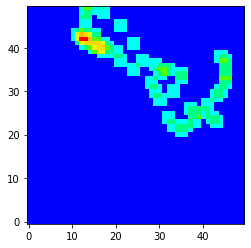

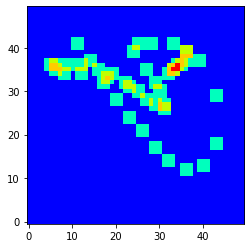

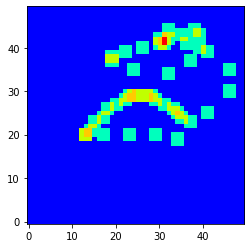

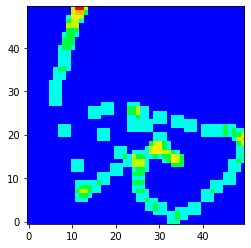

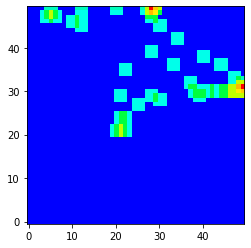

In [49]:
# p_group vs m_group
game = 2018090600
plays = frame_df.loc[(frame_df['gameId'] == game)]['playId'].unique().tolist()

for play in plays:
    plot_prob_heatmap(frame_df, 'offense_p_group', 50, 'offense_m_group', 50, game, play)

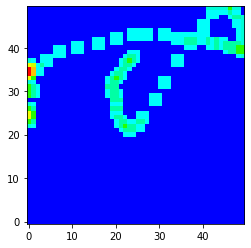

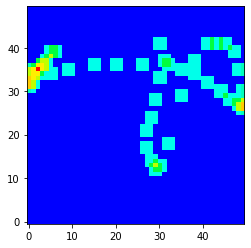

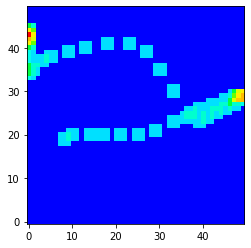

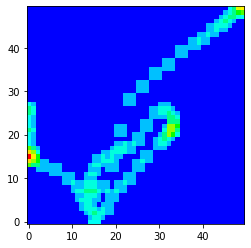

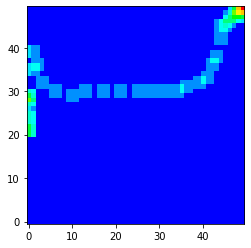

In [54]:
# p_group vs v_group
game = 2018090600
plays = frame_df.loc[(frame_df['gameId'] == game)]['playId'].unique().tolist()

for play in plays:
    plot_prob_heatmap(frame_df, 'offense_p_group', 50, 'offense_v_group', 50, game, play)

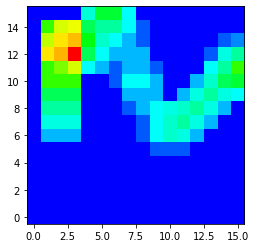

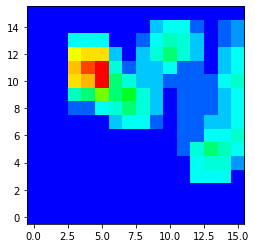

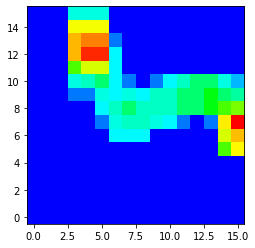

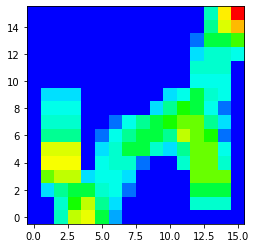

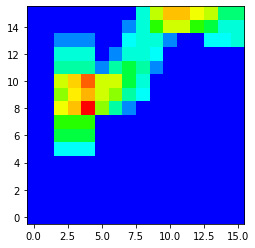

In [58]:
# p_group vs a_group
game = 2018090600
plays = frame_df.loc[(frame_df['gameId'] == game)]['playId'].unique().tolist()

for play in plays:
    plot_prob_heatmap(frame_df, 'offense_p_group', 16, 'offense_a_group', 16, game, play)